In [1]:
# Initialize OK
from client.api.notebook import Notebook
ok = Notebook('hw3.ok')

Assignment: hw3
OK, version v1.18.1



# Homework 3: Predicting Housing Prices

## Due Date: Fri 5/14, 11:59 PM

**Collaboration Policy:** You may talk with others about the homework, but we ask that you **write your solutions individually**. If you do discuss the assignments with others, please **include their names** in the following line.

**Collaborators**: *list collaborators here (if applicable)*

## Score Breakdown

Question | Points
--- | ---
[Question 1](#q1) | 3
[Question 2](#q2) | 2
[Question 3](#q3) | 1
[Question 4](#q4) | 1
[Question 5](#q5) | 2
[Question 6](#q6) | 2
[Question 7a](#q7a) | 1
[Question 7b](#q7b) | 2
[Question 8a](#q8a) | 1
[Question 8b](#q8b) | 1
[Question 8c](#q8c) | 2
[Question 8d](#q8d) | 2
Total | 20

## Introduction

We will go through the iterative process of specifying, fitting, and analyzing the performance of a model.  

In the first portion of the assignment, we will guide you through some basic exploratory data analysis (EDA), laying out the thought process that leads to certain modeling decisions. Next, you will add a new feature to the dataset, before specifying and fitting a linear model to a few features of the housing data to predict housing prices. Finally, we will analyze the error of the model and brainstorm ways to improve the model's performance.

After this homework, you should feel comfortable with the following:

1. Simple feature engineering
1. Using sklearn to build linear models
1. Building a data pipeline using pandas

Next homework will continue working with this dataset to address more advanced and subtle issues with modeling.

In [2]:
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Plot settings
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 12

# The Ames Housing Price Dataset

The [Ames dataset](http://jse.amstat.org/v19n3/decock.pdf) consists of 2930 records taken from the Ames, Iowa, Assessor’s Office describing houses sold in Ames from 2006 to 2010.  The data set has 23 nominal, 23 ordinal, 14 discrete, and 20 continuous variables (and 2 additional observation identifiers) --- 82 features in total. 

An explanation of each variable can be found in the included `codebook.txt` file. The information was used in computing assessed values for individual residential properties sold in Ames, Iowa from 2006 to 2010. **Some noise has been added to the actual sale price, so prices will not match official records.**

The data are split into training and test sets with 2000 and 930 observations, respectively.

In [3]:
training_data = pd.read_csv("./data/ames_train.csv")
test_data = pd.read_csv("./data/ames_test.csv")

As a good sanity check, we should at least verify that the data shape matches the description.

In [4]:
# 2000 observations and 82 features in training data
assert training_data.shape == (2000, 82)
# 930 observations and 81 features in test data
assert test_data.shape == (930, 81)
# SalePrice is hidden in the test data
assert 'SalePrice' not in test_data.columns.values
# Every other column in the test data should be in the training data
assert len(np.intersect1d(test_data.columns.values, 
                          training_data.columns.values)) == 81

The next order of business is getting a feel for the variables in our data.  The Ames dataset contains information that typical homebuyers would want to know. 

A more detailed description of each variable is included in `codebook.txt`.  **You should take some time to familiarize yourself with the codebook before moving forward.**

In [5]:
training_data.columns.values

array(['Order', 'PID', 'MS_SubClass', 'MS_Zoning', 'Lot_Frontage',
       'Lot_Area', 'Street', 'Alley', 'Lot_Shape', 'Land_Contour',
       'Utilities', 'Lot_Config', 'Land_Slope', 'Neighborhood',
       'Condition_1', 'Condition_2', 'Bldg_Type', 'House_Style',
       'Overall_Qual', 'Overall_Cond', 'Year_Built', 'Year_Remod/Add',
       'Roof_Style', 'Roof_Matl', 'Exterior_1st', 'Exterior_2nd',
       'Mas_Vnr_Type', 'Mas_Vnr_Area', 'Exter_Qual', 'Exter_Cond',
       'Foundation', 'Bsmt_Qual', 'Bsmt_Cond', 'Bsmt_Exposure',
       'BsmtFin_Type_1', 'BsmtFin_SF_1', 'BsmtFin_Type_2', 'BsmtFin_SF_2',
       'Bsmt_Unf_SF', 'Total_Bsmt_SF', 'Heating', 'Heating_QC',
       'Central_Air', 'Electrical', '1st_Flr_SF', '2nd_Flr_SF',
       'Low_Qual_Fin_SF', 'Gr_Liv_Area', 'Bsmt_Full_Bath',
       'Bsmt_Half_Bath', 'Full_Bath', 'Half_Bath', 'Bedroom_AbvGr',
       'Kitchen_AbvGr', 'Kitchen_Qual', 'TotRms_AbvGrd', 'Functional',
       'Fireplaces', 'Fireplace_Qu', 'Garage_Type', 'Garage_Yr_Blt',

# Part 1: Exploratory Data Analysis

In this section, we will make a series of exploratory visualizations and interpret them.

Note that we will perform EDA on the **training data** so that information from the test data does not influence our modeling decisions.

### Sale Price
We begin by examining a [raincloud plot](https://micahallen.org/2018/03/15/introducing-raincloud-plots/amp/?__twitter_impression=true) (a combination of a KDE, a histogram, a strip plot, and a box plot) of our target variable `SalePrice`.  At the same time, we also take a look at some descriptive statistics of this variable.

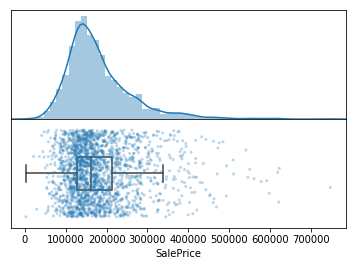

In [6]:
fig, axs = plt.subplots(nrows=2)

sns.distplot(
    training_data['SalePrice'], 
    ax=axs[0]
)
sns.stripplot(
    training_data['SalePrice'], 
    jitter=0.4, 
    size=3,
    ax=axs[1],
    alpha=0.3
)
sns.boxplot(
    training_data['SalePrice'],
    width=0.3, 
    ax=axs[1],
    showfliers=False,
)

# Align axes
spacer = np.max(training_data['SalePrice']) * 0.05
xmin = np.min(training_data['SalePrice']) - spacer
xmax = np.max(training_data['SalePrice']) + spacer
axs[0].set_xlim((xmin, xmax))
axs[1].set_xlim((xmin, xmax))

# Remove some axis text
axs[0].xaxis.set_visible(False)
axs[0].yaxis.set_visible(False)
axs[1].yaxis.set_visible(False)

# Put the two plots together
plt.subplots_adjust(hspace=0)

# Adjust boxplot fill to be white
axs[1].artists[0].set_facecolor('white')

In [7]:
training_data['SalePrice'].describe()

count      2000.000000
mean     180775.897500
std       81581.671741
min        2489.000000
25%      128600.000000
50%      162000.000000
75%      213125.000000
max      747800.000000
Name: SalePrice, dtype: float64

<br/><br/><br/>
<hr style="border: 5px solid #990000;" />
<hr style="border: 1px solid #dbbcac;" />

## Question 1  <a name="q1"></a>
To check your understanding of the graph and summary statistics above, answer the following `True` or `False` questions:

1. The distribution of `SalePrice` in the training set is left-skew.
1. The mean of `SalePrice` in the training set is greater than the median.
1. At least 25% of the houses in the training set sold for more than \$200,000.00.

*The provided tests for this question do not confirm that you have answered correctly; only that you have assigned each variable to `True` or `False`.*

<!--
BEGIN QUESTION
name: q1
points: 3
-->

In [8]:
# These should be True or False
q1statement1 = False
q1statement2 = True
q1statement3 = True

In [9]:
ok.grade("q1");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 4
    Failed: 0
[ooooooooook] 100.0% passed



### SalePrice vs Gr_Liv_Area

Next, we visualize the association between `SalePrice` and `Gr_Liv_Area`.  The `codebook.txt` file tells us that `Gr_Liv_Area` measures "above grade (ground) living area square feet."

This variable represents the square footage of the house excluding anything underground.  Some additional research (into real estate conventions) reveals that this value also excludes the garage space.

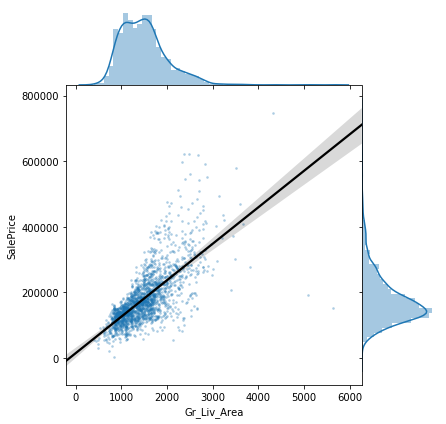

In [10]:
sns.jointplot(
    x='Gr_Liv_Area', 
    y='SalePrice', 
    data=training_data,
    stat_func=None,
    kind="reg",
    ratio=4,
    space=0,
    scatter_kws={
        's': 3,
        'alpha': 0.25
    },
    line_kws={
        'color': 'black'
    }
);

There's certainly an association, and perhaps it's linear, but the spread is wider at larger values of both variables.  Also, there are two particularly suspicious houses above 5000 square feet that look too inexpensive for their size.


<br/><br/><br/>
<hr style="border: 5px solid #990000;" />
<hr style="border: 1px solid #dbbcac;" />

## Question 2 <a name="q2"></a>
What are the Parcel Indentification Numbers for the two houses with `Gr_Liv_Area` greater than 5000 sqft?

*The provided tests for this question do not confirm that you have answered correctly; only that you have assigned `q2house1` and `q2house2` to two integers that are in the range of PID values.*

<!--
BEGIN QUESTION
name: q2
points: 2
-->

In [11]:
# BEGIN YOUR CODE
# -----------------------
# Hint: You can answer this question in one line
q2house1, q2house2 = training_data.loc[training_data['Gr_Liv_Area'] > 5000]['PID']
# -----------------------
# END YOUR CODE

In [12]:
ok.grade("q2");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 5
    Failed: 0
[ooooooooook] 100.0% passed



<br/><br/><br/>
<hr style="border: 5px solid #990000;" />
<hr style="border: 1px solid #dbbcac;" />

## Question 3 <a name="q3"></a>

The codebook tells us how to manually inspect the houses using an online database called Beacon. These two houses are true outliers in this data set: they aren't the same time of entity as the rest. They were partial sales, priced far below market value. If you would like to inspect the valuations, follow the directions at the bottom of the codebook to access Beacon and look up houses by PID.

For this assignment, we will remove these outliers from the data. Write a function `remove_outliers` that removes outliers from a data set based off a threshold value of a variable.  For example, `remove_outliers(training_data, 'Gr_Liv_Area', upper=5000)` should return a data frame with only observations that satisfy `Gr_Liv_Area` less than or equal to 5000.

*The provided tests check that training_data was updated correctly, so that future analyses are not corrupted by a mistake. However, the provided tests do not check that you have implemented remove_outliers correctly so that it works with any data, variable, lower, and upper bound.*

<!--
BEGIN QUESTION
name: q3
points: 1
-->

In [13]:
def remove_outliers(data, variable, lower=-np.inf, upper=np.inf):
    """
    Input:
      data (data frame): the table to be filtered
      variable (string): the column with numerical outliers
      lower (numeric): observations with values lower than this will be removed
      upper (numeric): observations with values higher than this will be removed
    
    Output:
      a winsorized data frame with outliers removed
      
    Note: This function should not change mutate the contents of data.
    """
    # BEGIN YOUR CODE
    # -----------------------
    return data.loc[(data[variable] <= upper) & (data[variable] >= lower)]
    # -----------------------
    # END YOUR CODE

training_data = remove_outliers(training_data, 'Gr_Liv_Area', upper=5000)

In [14]:
ok.grade("q3");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 5
    Failed: 0
[ooooooooook] 100.0% passed



# Part 2: Feature Engineering

In this section we will create a new feature out of existing ones through a simple data transformation.

### Bathrooms

Let's create a groundbreaking new feature. Due to recent advances in Universal WC Enumeration Theory, we now know that Total Bathrooms can be calculated as:

$$ \text{TotalBathrooms}=(\text{BsmtFullBath} + \text{FullBath}) + \dfrac{1}{2}(\text{BsmtHalfBath} + \text{HalfBath})$$

The actual proof is beyond the scope of this class, but we will use the result in our model.

<br/><br/><br/>
<hr style="border: 5px solid #990000;" />
<hr style="border: 1px solid #dbbcac;" />

## Question 4 <a name="q4"></a>

Write a function `add_total_bathrooms(data)` that returns a `copy of data` with an additional column called `TotalBathrooms` computed by the formula above.

*The provided tests check that you answered correctly, so that future analyses are not corrupted by a mistake.*

<!--
BEGIN QUESTION
name: q4
points: 1
-->

In [18]:
def add_total_bathrooms(data):
    """
    Input:
      data (data frame): a data frame containing at least 4 numeric columns 
            Bsmt_Full_Bath, Full_Bath, Bsmt_Half_Bath, and Half_Bath
    """
    with_bathrooms = data.copy()
    bath_vars = ['Bsmt_Full_Bath', 'Full_Bath', 'Bsmt_Half_Bath', 'Half_Bath']
    weights = pd.Series([1, 1, 0.5, 0.5], index=bath_vars)
    with_bathrooms = with_bathrooms.fillna({var: 0 for var in bath_vars})
    # BEGIN YOUR CODE
    # -----------------------
    with_bathrooms['TotalBathrooms'] = with_bathrooms[bath_vars].dot(weights)
    # -----------------------
    # END YOUR CODE
    return with_bathrooms

training_data = add_total_bathrooms(training_data)

In [19]:
ok.grade("q4");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 4
    Failed: 0
[ooooooooook] 100.0% passed



<br/><br/><br/>
<hr style="border: 5px solid #990000;" />
<hr style="border: 1px solid #dbbcac;" />

## Question 5 <a name="q5"></a>

Create a visualization that clearly and succintly shows that `TotalBathrooms` is associated with `SalePrice`. Your visualization should avoid overplotting.

<!--
BEGIN QUESTION
name: q5
points: 2
manual: True
format: image
-->
<!-- EXPORT TO PDF format:image -->

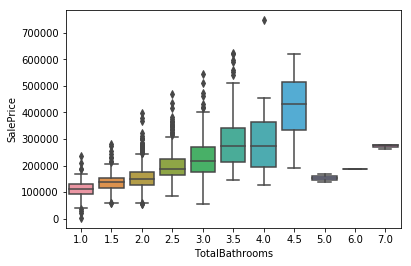

In [20]:
# BEGIN YOUR CODE
# -----------------------
sns.boxplot(training_data['TotalBathrooms'], training_data['SalePrice']);
# -----------------------
# END YOUR CODE

# Part 3: Modeling

We've reached the point where we can specify a model. But first, we will load a fresh copy of the data, just in case our code above produced any undesired side-effects. Run the cell below to store a fresh copy of the data from `ames_train.csv` in a dataframe named `full_data`. We will also store the number of rows in `full_data` in the variable `full_data_len`.

In [21]:
# Load a fresh copy of the data and get its length
full_data = pd.read_csv("./data/ames_train.csv")
full_data_len = len(full_data)
full_data.head()

,Order,PID,MS_SubClass,MS_Zoning,Lot_Frontage,Lot_Area,Street,Alley,Lot_Shape,Land_Contour,...,Pool_Area,Pool_QC,Fence,Misc_Feature,Misc_Val,Mo_Sold,Yr_Sold,Sale_Type,Sale_Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,204900
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,95300
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,181900
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,254100
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,199700


<br/><br/><br/>
<hr style="border: 5px solid #990000;" />
<hr style="border: 1px solid #dbbcac;" />

## Question 6 <a name="q6"></a>

Now, let's split the data set into a training set and test set. We will use the training set to fit our model's parameters, and we will use the test set to estimate how well our model will perform on unseen data drawn from the same distribution. If we used all the data to fit our model, we would not have a way to estimate model performance on unseen data.

"Don't we already have a test set in `ames_test.csv`?" you might wonder. The sale prices for `ames_test.csv` aren't provided, so we're constructing our own test set for which we know the outputs.

In the cell below, split the data in `full_data` into two DataFrames named `train` and `test`. Let `train` contain 80% of the data, and let `test` contain the remaining 20% of the data. 

To do this, first create two NumPy arrays named `train_indices` and `test_indices`. `train_indices` should contain a *random* 80% of the indices in `full_data`, and `test_indices` should contain the remaining 20% of the indices. Then, use these arrays to index into `full_data` to create your final `train` and `test` DataFrames.

*The provided tests check that you not only answered correctly, but ended up with the exact same train/test split as our reference implementation. Later testing is easier this way.*

<!--
BEGIN QUESTION
name: q6
points: 2
-->

In [22]:
# This makes the train-test split in this section reproducible across different runs 
# of the notebook. You do not need this line to run train_test_split in general
np.random.seed(1337)
shuffled_indices = np.random.permutation(full_data_len)

# Set train_indices to the first 80% of shuffled_indices and and test_indices to the rest.
# BEGIN YOUR CODE
# -----------------------
part_flag = int(len(shuffled_indices)*0.8)
train_indices = shuffled_indices[:part_flag]
test_indices = shuffled_indices[part_flag:]
# -----------------------
# END YOUR CODE

# Create train and test` by indexing into `full_data` using 
# `train_indices` and `test_indices`
# BEGIN YOUR CODE
# -----------------------
train = full_data.loc[train_indices]
test = full_data.loc[test_indices]
# -----------------------
# END YOUR CODE

In [23]:
ok.grade("q6");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 6
    Failed: 0
[ooooooooook] 100.0% passed



### Reusable Pipeline

Throughout this assignment, you should notice that your data flows through a single processing pipeline several times.  From a software engineering perspective, it's best to define functions/methods that can apply the pipeline to any dataset.  We will now encapsulate our entire pipeline into a single function `process_data_gm`.  gm is shorthand for "guided model". We select a handful of features to use from the many that are available.

In [25]:
def select_columns(data, *columns):
    """Select only columns passed as arguments."""
    return data.loc[:, columns]

def process_data_gm(data):
    """Process the data for a guided model."""
    data = remove_outliers(data, 'Gr_Liv_Area', upper=5000)
    
    # Transform Data, Select Features
    data = add_total_bathrooms(data)
    data = select_columns(data, 
                          'SalePrice', 
                          'Gr_Liv_Area', 
                          'Garage_Area',
                          'TotalBathrooms',
                         )
    
    # Return predictors and response variables separately
    X = data.drop(['SalePrice'], axis = 1)
    y = data.loc[:, 'SalePrice']
    
    return X, y

Now, we can use `process_data_gm` to clean our data, select features, and add our `TotalBathrooms` feature all in one step! This function also splits our data into `X`, a matrix of features, and `y`, a vector of sale prices. 

Run the cell below to feed our training and test data through the pipeline, generating `X_train`, `y_train`, `X_test`, and `y_test`.

In [26]:
# Pre-process our training and test data in exactly the same way
# Our functions make this very easy!
X_train, y_train = process_data_gm(train)
X_test, y_test = process_data_gm(test)

### Fitting Our First Model

We are finally going to fit a model!  The model we will fit can be written as follows:

$$\text{SalePrice} = \theta_0 + \theta_1 \cdot \text{Gr_Liv_Area} + \theta_2 \cdot \text{Garage_Area} + \theta_3 \cdot \text{TotalBathrooms}$$

In vector notation, the same equation would be written:

$$y = \theta \cdot x$$

where y is the SalePrice, $\theta$ is a vector of all fitted weights, and x contains a 1 for the bias followed by each of the feature values.

**Note:** Notice that all of our variables are continuous, except for `TotalBathrooms`, which takes on discrete ordered values (0, 0.5, 1, 1.5, ...). In this homework, we'll treat `TotalBathrooms` as a continuous quantitative variable in our model, but this might not be the best choice. The next homework may revisit the issue.

<br/><br/><br/>
<hr style="border: 5px solid #990000;" />
<hr style="border: 1px solid #dbbcac;" />

## Question 7a <a name="q7a"></a>

We will use a [`sklearn.linear_model.LinearRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) object as our linear model. In the cell below, create a `LinearRegression` object and name it `linear_model`.

**Hint:** See the `fit_intercept` parameter and make sure it is set appropriately. The intercept of our model corresponds to $\theta_0$ in the equation above.

*The provided tests check that you answered correctly, so that future analyses are not corrupted by a mistake.*

<!--
BEGIN QUESTION
name: q7a
points: 1
-->

In [27]:
from sklearn import linear_model as lm

# BEGIN YOUR CODE
# -----------------------
linear_model = lm.LinearRegression(fit_intercept = True)
# -----------------------
# END YOUR CODE

In [28]:
ok.grade("q7a");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 2
    Failed: 0
[ooooooooook] 100.0% passed



<br/><br/><br/>
<hr style="border: 5px solid #990000;" />
<hr style="border: 1px solid #dbbcac;" />

## Question 7b <a name="q7b"></a>

Now, remove the commenting and fill in the ellipses `...` below with `X_train`, `y_train`, `X_test`, or `y_test`.

With the ellipses filled in correctly, the code below should fit our linear model to the training data and generate the predicted sale prices for both the training and test datasets.

*The provided tests check that you answered correctly, so that future analyses are not corrupted by a mistake.*

<!--
BEGIN QUESTION
name: q7b
points: 2
-->

In [29]:
# Uncomment the lines below and fill in the ... with X_train, y_train, X_test, or y_test.
# BEGIN YOUR CODE
# -----------------------
linear_model.fit(X_train, y_train)
y_fitted = linear_model.predict(X_train)
y_predicted = linear_model.predict(X_test)
# -----------------------
# END YOUR CODE

In [30]:
ok.grade("q7b");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 2
    Failed: 0
[ooooooooook] 100.0% passed



<br/><br/><br/>
<hr style="border: 5px solid #990000;" />
<hr style="border: 1px solid #dbbcac;" />

## Question 8a <a name="q8a"></a>

Is our linear model any good at predicting house prices? Let's measure the quality of our model by calculating the Root-Mean-Square Error (RMSE) between our predicted house prices and the true prices stored in `SalePrice`.

$$\text{RMSE} = \sqrt{\dfrac{\sum_{\text{houses in test set}}(\text{actual price of house} - \text{predicted price of house})^2}{\text{# of houses in data set}}}$$

In the cell below, write a function named `rmse` that calculates the RMSE of a model.

**Hint:** Make sure you are taking advantage of vectorized code. This question can be answered without any `for` statements.

*The provided tests check that you answered correctly, so that future analyses are not corrupted by a mistake.*

<!--
BEGIN QUESTION
name: q8a
points: 1
-->

In [31]:
def rmse(actual, predicted):
    """
    Calculates RMSE from actual and predicted values
    Input:
      actual (1D array): vector of actual values
      predicted (1D array): vector of predicted/fitted values
    Output:
      a float, the root-mean square error
    """
    # BEGIN YOUR CODE
    # -----------------------
    import math
    num = ((actual - predicted)**2)
    num = num.sum()
    denum = len(actual)
    result = math.sqrt(num/denum)
    return result
    # -----------------------
    # END YOUR CODE

In [32]:
ok.grade("q8a");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 2
    Failed: 0
[ooooooooook] 100.0% passed



<br/><br/><br/>
<hr style="border: 5px solid #990000;" />
<hr style="border: 1px solid #dbbcac;" />

## Question 8b <a name="q8b"></a>

Now use your `rmse` function to calculate the training error and test error in the cell below.

*The provided tests for this question do not confirm that you have answered correctly; only that you have assigned each variable to a non-negative number.*

<!--
BEGIN QUESTION
name: q8b
points: 1
-->

In [33]:
# BEGIN YOUR CODE
# -----------------------
training_error = rmse(y_train, y_fitted)
test_error = rmse(y_test, y_predicted)
# -----------------------
# END YOUR CODE
(training_error, test_error)

(46710.597505875856, 46146.64265682625)

In [34]:
ok.grade("q8b");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 4
    Failed: 0
[ooooooooook] 100.0% passed



<br/><br/><br/>
<hr style="border: 5px solid #990000;" />
<hr style="border: 1px solid #dbbcac;" />

## Question 8c <a name="q8c"></a>

How much does including `TotalBathrooms` as a predictor reduce the RMSE of the model on the test set? That is, what's the difference between the RSME of a model that only includes `Gr_Liv_Area` and `Garage_Area` versus one that includes all three predictors?

*The provided tests for this question do not confirm that you have answered correctly; only that you have assigned the answer variable to a non-negative number.*

<!--
BEGIN QUESTION
name: q8c
points: 2
-->

In [39]:
# BEGIN YOUR CODE
# -----------------------
def process_data_gm_new(data):
    data = remove_outliers(data, 'Gr_Liv_Area', upper = 5000)
    data = add_total_bathrooms(data)
    data = select_columns(data,
                          'SalePrice',
                          'Gr_Liv_Area', 
                          'Garbage_Area',)
    X = data.drop(['SalePrice'], axis = 1)
    y = data.loc[:, 'SalePrice']
    
    return X, y

X_train_new, y_train_new = process_data_gm_new(train)
X_test_new, y_test_new = process_data_gm_new(test)

from sklearn.linear_model import LinearRegression
linear_model_new = LinearRegression(fit_intercept = True).fit(X_train_new, y_train_new)
y_fitted_new = linear_model_new.predict(X_train_new)
y_predicted_new = linear_model_new.predict(X_test_new)

test_error_no_bath = rmse(y_test, y_predicted_new)
# -----------------------
# END YOUR CODE

test_error_difference = test_error_no_bath - test_error
test_error_difference

/Users/choijaewon/opt/anaconda3/envs/cose471/lib/python3.6/site-packages/pandas/core/indexing.py:870: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_lowerdim(tup)


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [127]:
ok.grade("q8c");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
q8c > Suite 1 > Case 1

>>> test_error_difference >= 0
NameError: name 'test_error_difference' is not defined

# Error: expected
#     True
# but got
#     Traceback (most recent call last):
#       ...
#     NameError: name 'test_error_difference' is not defined

Run only this test case with "python3 ok -q q8c --suite 1 --case 1"
---------------------------------------------------------------------
Test summary
    Passed: 0
    Failed: 1
[k..........] 0.0% passed



### Residual Plots

One way of understanding the performance (and appropriateness) of a model is through a residual plot. Run the cell below to plot the actual sale prices against the residuals of the model for the test data.

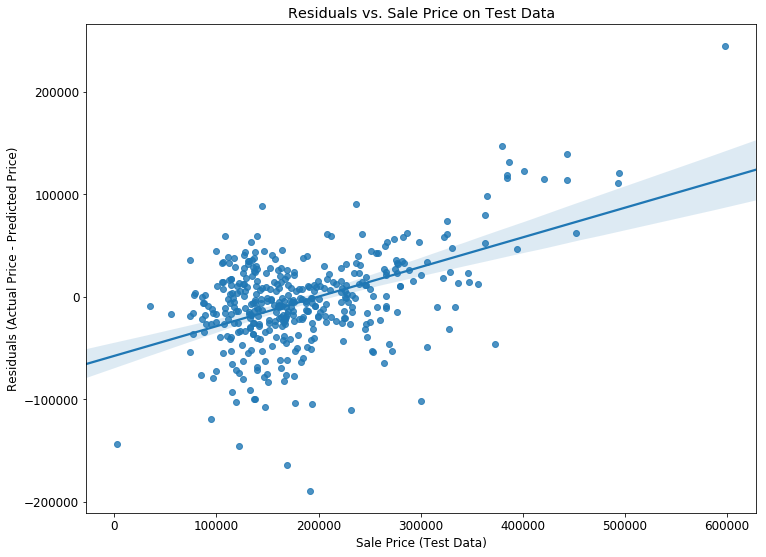

In [72]:
residuals = y_test - y_predicted
ax = sns.regplot(y_test, residuals)
ax.set_xlabel('Sale Price (Test Data)')
ax.set_ylabel('Residuals (Actual Price - Predicted Price)')
ax.set_title("Residuals vs. Sale Price on Test Data");

Ideally, we would see a horizontal line of points at 0 (perfect prediction!). The next best thing would be a homogenous set of points centered at 0. 

But alas, our simple model is probably too simple. The most expensive homes are systematically more expensive than our prediction. 

<br/><br/><br/>
<hr style="border: 5px solid #990000;" />
<hr style="border: 1px solid #dbbcac;" />

## Question 8d <a name="q8c"></a>

What changes could you make to your linear model to improve its accuracy and lower the test error? Suggest at least two things you could try in the cell below, and carefully explain how each change could potentially improve your model's accuracy.

<!--
BEGIN QUESTION
name: q8d
points: 2
manual: True
-->
<!-- EXPORT TO PDF -->

Answer: 
1. 더 많은 데이터 샘플을 제공한다. 학습 알고리즘이 더 많은 데이터를 학습할수록 정확히 식별하는 겨우가 늘어난다.
2. Cross-Validation test를 하도록 한다. 이 test는 학습 데이터 중 일부를 학습시켜 모델을 생성하고 나머지 데이터는 모델을 검증하는데 사용한다. 이로서 정확도가 좋은 모델을 만들 수 있다.

**SOLUTION:** We could add more features that are likely to correlate with expensive houses. We could also encode the neighborhoods as features, as houses from the same neighborhood might be closer in price. We could also introduce regularization to improve our model.

<br/><br/><br/>
<hr style="border: 5px solid #990000;" />
<hr style="border: 1px solid #dbbcac;" />

### Congratulations! You have completed HW3.

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output.,

**Please save before submitting!**

Please generate pdf as follows and submit it to Gradescope.

**File > Print Preview > Print > Save as pdf**

<!-- EXPECT 2 EXPORTED QUESTIONS -->